In [1]:
#Here I will work on "rainfaLL_rate" data
#import libraries
import boto3
import json
import urllib.request
import iris

In [2]:
#connect to sqs 
sqs = boto3.client('sqs', region_name='eu-west-2')

In [3]:
#creating an empty set to add files that contain rainfall_rate data
rainfall_rate = set()

In [30]:
#function to connect to queue and identify files that contain rainfall_rate data and adding those to set created earlier
#the queue created has following settings
#visibility timeout: 10 secs
#delivery delay : 5 min
#receive message wait time : 20 secs
#message retention period : 1 day
#Access Policy : Basic
#Who can send/receive messages to/from queue: only owner
#subscription : arn:aws:sns:eu-west-2:021908831235:aws-earth-mo-atmospheric-mogreps-uk-prd
#tag : environment/awstakehome
#Note** Deleted subscription to avoid more messages in queue while testing..

def sqsfunc():
    messages = sqs.receive_message(
    QueueUrl='https://sqs.eu-west-2.amazonaws.com/443602378074/MyQueueNew',
    MaxNumberOfMessages=10)
    for i in messages['Messages']:
        x = json.loads(i['Body'])
        y = json.loads(x['Message'])
        if y['name'] == "rainfall_rate":
            rainfall_rate.add(y["key"])
            print('rainfall_rate has now ' + str(len(rainfall_rate)) + ' files')
        return rainfall_rate

In [43]:
#run multiple times to get multiple files or atleast till set has one file
#will customize this to run in automated fashion in later stages

sqsfunc()

rainfall_rate has now 2 files


{'04236c715d30c4bcd6fff1d8b71adbff15dbfecf.nc',
 '19fd1e5d48111cff6e15a2f0facede7e125e4b60.nc'}

In [44]:
#function to download files
def download_data_object(rainfall_rate):
    for i in rainfall_rate:
        url = "https://s3.eu-west-2.amazonaws.com/" + "aws-earth-mo-atmospheric-mogreps-uk-prd" + "/" + i
        urllib.request.urlretrieve(url, i)

In [45]:
download_data_object(rainfall_rate)

In [46]:
rainfall_rate

{'04236c715d30c4bcd6fff1d8b71adbff15dbfecf.nc',
 '19fd1e5d48111cff6e15a2f0facede7e125e4b60.nc'}

In [47]:
#converting set to list
rainfall_rate = list(rainfall_rate)

In [48]:
rainfall_rate

['19fd1e5d48111cff6e15a2f0facede7e125e4b60.nc',
 '04236c715d30c4bcd6fff1d8b71adbff15dbfecf.nc']

In [50]:
#selecting one file
for i in rainfall_rate[0:1]:
    filename = i
    listofcubes = iris.load(filename)
    cube = listofcubes[0]
    print("--filename: " + i)
    print("--listofcubes in file: \n" ,listofcubes,end="\n--Printing Cube now\n")
    print(cube)
    realization = cube.coord('realization').points
    projection_y = cube.coord('projection_y_coordinate').points
    projection_x = cube.coord('projection_x_coordinate').points
   

--filename: 19fd1e5d48111cff6e15a2f0facede7e125e4b60.nc
--listofcubes in file: 
 0: rainfall_rate / (m s-1)             (realization: 3; projection_y_coordinate: 970; projection_x_coordinate: 1042)
--Printing Cube now
rainfall_rate / (m s-1)             (realization: 3; projection_y_coordinate: 970; projection_x_coordinate: 1042)
     Dimension coordinates:
          realization                           x                           -                             -
          projection_y_coordinate               -                           x                             -
          projection_x_coordinate               -                           -                             x
     Scalar coordinates:
          forecast_period: 115200 seconds
          forecast_reference_time: 2020-09-15 07:00:00
          time: 2020-09-16 15:00:00
     Attributes:
          Conventions: CF-1.5, UKMO-1.0
          history: 2020-09-15T09:03:21Z: StaGE Decoupler
          institution: Met Office
          

In [52]:
#number of dimensions for 'realization'
realization.size

3

In [53]:
#looking at values in 'realization'
print(realization)

[6 7 8]


In [54]:
#number of dimensions for projection_y_coordinate
projection_y.size

970

In [55]:
#number of dimensions for projection_x_coordinate
projection_x.size

1042

In [56]:
#cube dimensions
cube.ndim

3

In [57]:
#looking at shape
cube.shape

(3, 970, 1042)

In [58]:
 #Reducing dimension from 3d to 2d cube and plotting considering realization
extracted_cube = cube.extract(iris.Constraint(realization=6))

In [59]:
extracted_cube.ndim

2

In [60]:
extracted_cube

<iris 'Cube' of rainfall_rate / (m s-1) (projection_y_coordinate: 970; projection_x_coordinate: 1042)>

In [61]:
#plotting our rainfall_rate data
import matplotlib.pyplot as plt
import iris.quickplot as qplt

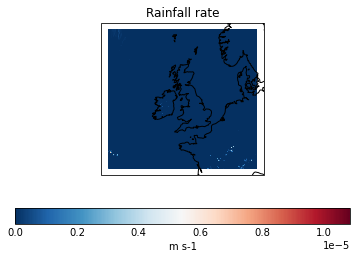

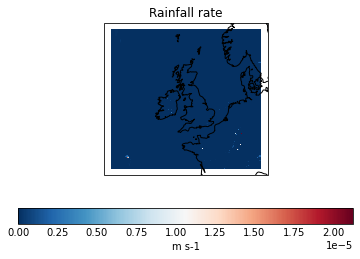

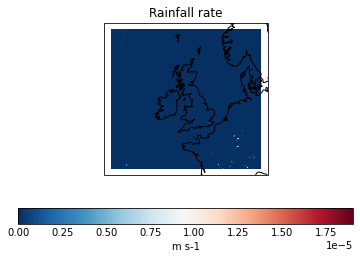

In [62]:
for i in realization:
    extracted_cube = cube.extract(iris.Constraint(realization=i))
    qplt.pcolormesh(extracted_cube,cmap='RdBu_r')
    plt.gca().coastlines()
    plt.show()

In [64]:
extracted_cube.shape
#shows 970 rows(projection_y_coordinate),1042 columns(projection_x_coordinate)

(970, 1042)

In [67]:
#confirming
len(projection_x)


1042

In [66]:
#confirming
len(projection_y)

970

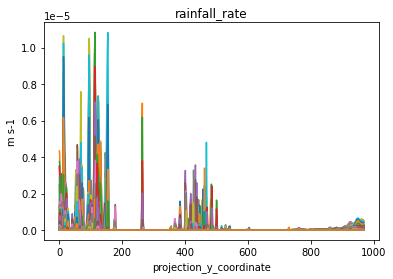

In [69]:
#plotting for one realization
 #Reducing dimension from 3d to 2d cube and plotting considering realization
extracted_cube = cube.extract(iris.Constraint(realization=6))
import pandas as pd
cubedf = pd.DataFrame(extracted_cube.data,columns=[projection_x])
plt.plot(cubedf)
plt.xlabel("projection_y_coordinate")
plt.ylabel(cube.units)
plt.title('rainfall_rate')
plt.show()


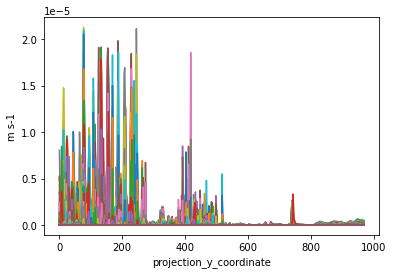

In [72]:
#plotting for all realization and downloading df_to_csv files
#this files can then be used to plot/visualize with different tools
df_to_csv = []
for i in realization:
    extracted_cube = cube.extract(iris.Constraint(realization=i))
    cubedf = pd.DataFrame(extracted_cube.data,columns=[projection_x])
    cubedf.columns.name = "projection_x"
    cubedf.to_csv('cubedf'+ '_' + str(i) + '.csv')
    df_to_csv.append('cubedf'+str(i) + '.csv')
    plt.plot(cubedf)
    plt.xlabel("projection_y_coordinate")
plt.ylabel(cube.units)
plt.show()


In [73]:
#looking at files downloaded and used for plot above
df_to_csv

['cubedf6.csv', 'cubedf7.csv', 'cubedf8.csv']

In [74]:
#looking at one of df created
cubedf.head()

,-1158000.0,-1156000.0,-1154000.0,-1152000.0,-1150000.0,-1148000.0,-1146000.0,-1144000.0,-1142000.0,-1140000.0,...,906000.0,908000.0,910000.0,912000.0,914000.0,916000.0,918000.0,920000.0,922000.0,924000.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
#dataframe column names are values as in projection_x
projection_x[0:10]

array([-1158000., -1156000., -1154000., -1152000., -1150000., -1148000.,
       -1146000., -1144000., -1142000., -1140000.], dtype=float32)